In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
#
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

import tools
import importlib
importlib.reload(tools)

/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


<module 'tools' from '/home/ec2-user/slack-trading/tools.py'>

### Download data from AWS S3

In [2]:
s3_bucket = 'slack-trading'
local_path = '../data'
tools.download_data_from_s3(s3_bucket, local_path)

### Begin

In [3]:
num_of_years = 1
start = dt.date.today() - dt.timedelta(days = int(365.25*num_of_years))
end = dt.date.today()

In [4]:
dataset = pd.read_csv('../data/all_stock_close.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', drop=True, inplace=True)
dataset.head(3)

,0001.HK,0002.HK,0003.HK,0004.HK,0006.HK,0008.HK,0010.HK,0011.HK,0012.HK,0014.HK,...,8535.HK,8601.HK,8607.HK,8609.HK,8613.HK,8622.HK,8635.HK,8668.HK,9900.HK,9988.HK
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-22,67.963409,76.052124,13.894835,18.090796,52.005646,4.286833,18.589355,153.497543,35.732788,27.409407,...,0.085,0.224,0.295,0.165,0.068,0.15,0.122253,0.161,1.44,NaN
2019-11-25,68.058136,76.621101,13.987528,18.090796,52.760033,4.352210,18.920959,155.502167,36.346428,27.551668,...,0.085,0.224,0.300,0.168,0.068,0.15,0.119319,0.164,1.44,NaN


In [5]:
prevday_returns = np.log(dataset.shift(1)/dataset.shift(2))
today_returns = np.log(dataset/dataset.shift(1))
#
stocks_prev = prevday_returns.columns.to_list()
stocks_today = today_returns.columns.to_list()
#
new_col = ['{}.prev'.format(c) for c in stocks_prev]
prevday_returns.columns = new_col
#
comb_df = pd.concat([prevday_returns, today_returns], axis=1)
comb_df.dropna(inplace=True)

In [6]:
prevday_returns = comb_df[new_col]
today_returns = comb_df[stocks_today]

In [7]:
def get_linear_regression(pair, prevday_returns, today_returns):
    catstock = pair['prev']
    column = pair['today']
    X = prevday_returns[[catstock]].copy()
    X = sm.add_constant(X)
    y = today_returns[[column]]
    model = sm.OLS(y, X).fit()
    data = {
        'Prev' : catstock,
        'Today' : column,
        'Params' : model.params.iloc[1],
        'TValues' : abs(model.tvalues.iloc[1]),
        'RSquared' : model.rsquared
    }
    return data

### Non parallel processing

In [ ]:
%%time
catstocks = new_col
catstocks = ['0008.HK.prev', '0010.HK.prev']
pair_list = []
for catstock in catstocks:
    for column in today_returns.columns:
        if column not in catstock:
            data = {
                'prev' : catstock,
                'today' : column
            }
            pair_list.append(data)
#
results = [get_linear_regression(pair, prevday_returns, today_returns) for pair in pair_list]
result_df = pd.DataFrame(results)
result_df

### Parrallel processing

In [8]:
%%time
# catstocks = new_col
catstocks = ['0008.HK.prev', '0010.HK.prev']
pair_list = []
for catstock in catstocks:
    for column in today_returns.columns:
        if column not in catstock:
            data = {
                'prev' : catstock,
                'today' : column
            }
            pair_list.append(data)
#
cpu = cpu_count()
print('cpu count = {}'.format(cpu))
executor = Parallel(n_jobs=cpu, backend='multiprocessing')
tasks = (delayed(get_linear_regression)(pair, prevday_returns, today_returns) for pair in pair_list)
results = executor(tasks)
result_df = pd.DataFrame(results)
result_df

cpu count = 2


/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/base/mo

CPU times: user 369 ms, sys: 53.4 ms, total: 422 ms
Wall time: 9.26 s


,Prev,Today,Params,TValues,RSquared
0,0008.HK.prev,0001.HK,0.134769,1.159296,0.007936
1,0008.HK.prev,0002.HK,0.106156,1.389114,0.011356
2,0008.HK.prev,0003.HK,0.144053,1.640381,0.015764
3,0008.HK.prev,0004.HK,0.071635,0.514381,0.001572
4,0008.HK.prev,0006.HK,0.178079,2.059992,0.024637
...,...,...,...,...,...
2789,0010.HK.prev,8622.HK,0.173026,0.752760,0.003362
2790,0010.HK.prev,8635.HK,-0.056804,0.351786,0.000736
2791,0010.HK.prev,8668.HK,-0.246351,1.106440,0.007234
2792,0010.HK.prev,9900.HK,-0.009542,0.055654,0.000018


In [9]:
result_df.to_csv('../data/regression_pair.csv')

### Read Regression Result

In [10]:
result_df = pd.read_csv('../data/regression_pair.csv', index_col=0)

In [11]:
sorted_df = result_df.sort_values(by='RSquared', ascending=False)
sorted_df.head(10)

,Prev,Today,Params,TValues,RSquared
1336,0008.HK.prev,8237.HK,-2.574342,5.206547,0.138939
1585,0010.HK.prev,0267.HK,-0.355816,4.249941,0.097075
2226,0010.HK.prev,1658.HK,-0.254058,4.193346,0.094750
852,0008.HK.prev,1716.HK,1.776416,4.192939,0.094734
1801,0010.HK.prev,0693.HK,0.240257,3.857147,0.081353
2141,0010.HK.prev,1401.HK,0.742558,3.775981,0.078230
644,0008.HK.prev,1166.HK,-0.860683,3.771741,0.078068
794,0008.HK.prev,1570.HK,0.193704,3.706402,0.075589
2769,0010.HK.prev,8425.HK,-0.670052,3.705398,0.075551
1485,0010.HK.prev,0126.HK,0.244563,3.613791,0.072128


### Analyze the Top pair

0008.HK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Total prev stock rise 69
Total prev stock rise and today rise 17


/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


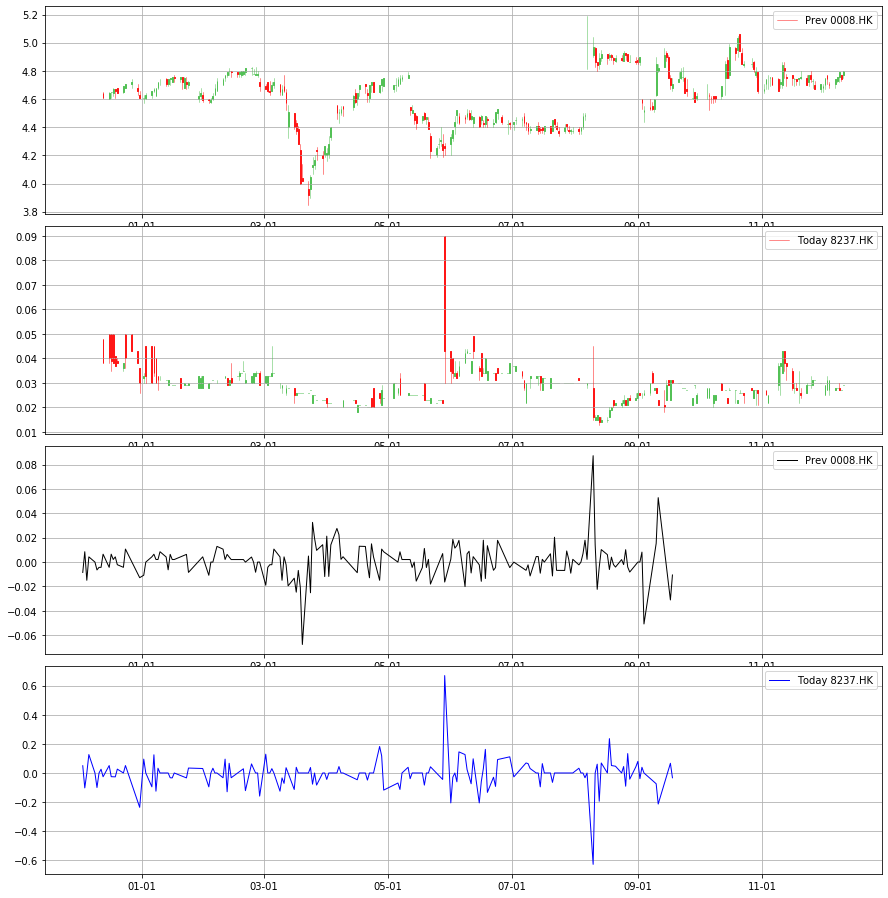

In [12]:
stock1 = '0008.HK.prev'
stock2 = '8237.HK'
#
tools.plot_two_stocks(stock1, stock2, prevday_returns, today_returns, start)